# Hard spheres model development


First stage: Develop a CNN - based GAN to work with ordered point clouds.

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Basic
from IPython.display import display

# For OS-agnostic paths
from pathlib import Path

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import numpy as np
sns.set_style("whitegrid")
from copy import deepcopy
import glob, json
from datetime import datetime
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, Dataset, TensorDataset


from torchinfo import summary

import mlflow

%cd ..

from src.utils import load_raw_data
from src.plotting import plot_pointcloud, plot_sample_figures
from src.models.HardSphereGAN import GAN, HSGenerator, HSDiscriminator

%cd -

plt.set_cmap("viridis")

/Users/veikko/Documents/GitHub/hard-spheres
/Users/veikko/Documents/GitHub/hard-spheres/Notebooks


<Figure size 640x480 with 0 Axes>

In [3]:
import os

os.environ["MLFLOW_ENABLE_SYSTEM_METRICS_LOGGING"] = "true"

## Load data

In [4]:

phis = [0.86] # Add more phis here

path = Path("../data/raw/samples")

files, dataframe, metadata = load_raw_data(path, phi=phis)

dataframe

Number of Files found :  526


class          x          y         r
experiment sample                                           
phi-0.86   sample-245      1 -21.345870 -15.024694  0.730000
           sample-245      2  20.038204 -19.199467  0.776842
           sample-245      3 -19.955206 -14.443004  0.823684
           sample-245      6 -13.669206 -10.131996  0.964211
           sample-245      4  -9.936614  -7.810038  0.870526
...                      ...        ...        ...       ...
           sample-468      2  15.738703 -21.721624  0.776842
           sample-468      3 -19.316748 -18.640416  0.823684
           sample-468     10  21.513569 -16.596960  1.151579
           sample-468      4 -17.922827 -19.644332  0.870526
           sample-468      6 -20.417054 -13.410191  0.964211

[1052000 rows x 4 columns]

In [5]:
dataframe["r"].describe().round(2)

count    1052000.00
mean           0.99
std            0.24
min            0.73
25%            0.78
50%            0.92
75%            1.15
max            1.62
Name: r, dtype: float64

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

dataframe_scaled = pd.DataFrame(scaler.fit_transform(dataframe), columns=dataframe.columns)

dataframe_scaled.set_index(dataframe.index, inplace=True)

dataframe_scaled = dataframe_scaled.drop(columns=["class"]) # Redundant with r

### IMPORTANT: Order dataframe based on Xy coordinates

This is done to introduce the spatial relationship that a CNN can utilize.


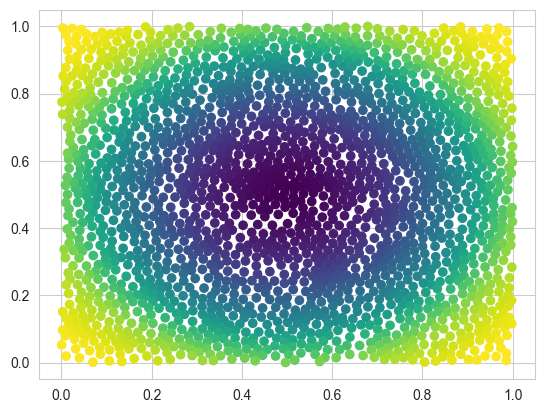

In [7]:
_X = dataframe_scaled.copy()
_X["Xy"] = _X["x"] + _X["y"] # Think about starting from center and going radially outwards


_X["Xy"] = np.sqrt(((_X["x"]-0.5)**2) + ((_X["y"]-0.5)**2))

_X = _X.query("experiment=='phi-0.86'&sample=='sample-1'")

_X = _X.sort_values(by=["Xy", "x", "y"])

_X = _X.reset_index(drop=True)

_X

plt.scatter(x=_X.values[:,0], y=_X.values[:,1], c=_X.index)


This is better than not ordered, but can be problematic as values in the middle have a high probability of ending up with non-neighbouring samples.

However it is also a good experiment as if we observe that the corners behave better than the middle, we know we are on to something.

In [8]:
dataframe_scaled_ordered = dataframe_scaled.copy()
dataframe_scaled_ordered["Xy"] = np.sqrt(((dataframe_scaled_ordered["x"]-0.5)**2) + ((dataframe_scaled_ordered["y"]-0.5)**2))
dataframe_scaled_ordered = dataframe_scaled_ordered.sort_values(by=["experiment", "sample", "Xy"])
dataframe_scaled_ordered = dataframe_scaled_ordered.drop(columns=["Xy"])

## Build dataset

In [9]:
from src.HSDataset import HSDataset

dataset = HSDataset(dataframe_scaled_ordered, descriptor_list=["phi"])

Creating Dataset
Descriptor List:  ['phi']


In [10]:
print(dataset[:][0].shape)
print(dataset[:][1].shape)

torch.Size([526, 1, 3])
torch.Size([526, 2000, 3])


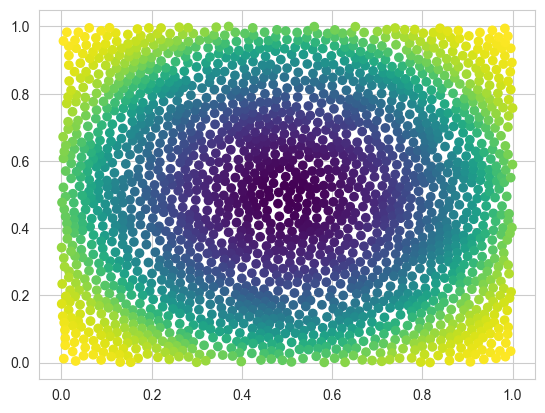

In [11]:
plt.scatter(x=dataset[2][1][:,0], y=dataset[2][1][:,1], c=list(range(len(dataset[2][1]))))


In [12]:
dataframe.query("sample=='sample-245'")[["x","y","r"]].values

array([[-21.34587012, -15.02469364,   0.73      ],
       [ 20.03820397, -19.19946735,   0.77684211],
       [-19.95520627, -14.44300365,   0.82368421],
       ...,
       [  2.33659102, -16.8469983 ,   1.01105263],
       [ 11.46064351,  21.25851651,   0.77684211],
       [-20.90681448, -17.45086112,   0.96421053]])

<Axes: >

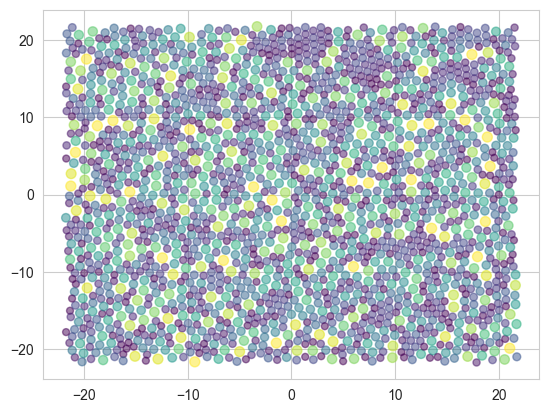

In [13]:
# Create a function that visualizes the point cloud

plot_pointcloud(dataframe.query("sample=='sample-245'")[["x","y","r"]].values, plot_radius=True)

<Axes: >

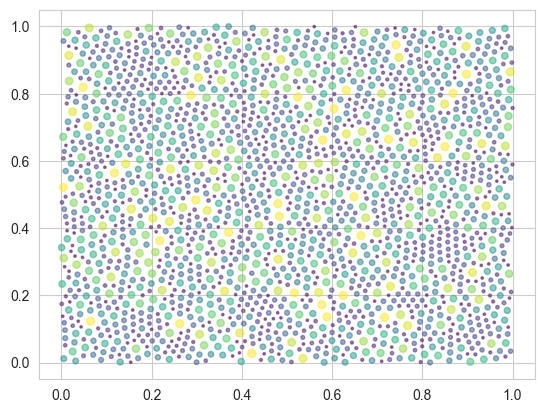

In [14]:
plot_pointcloud(dataset[2][1], plot_radius=True)

## Note: Samples are order invariant in the sample size dimension

<Axes: >

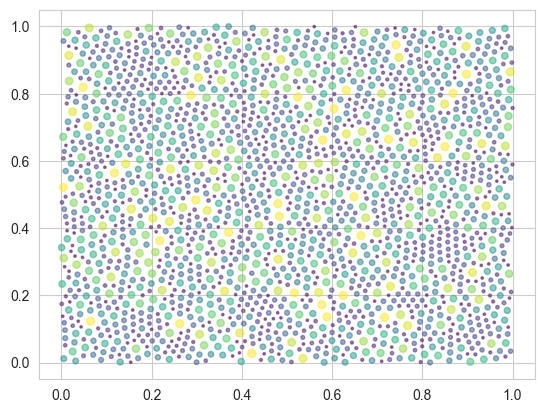

In [15]:
plot_pointcloud(reversed(dataset[2][1]), plot_radius=True)


## Check on x, y, r distributions

<Axes: xlabel='r', ylabel='Count'>

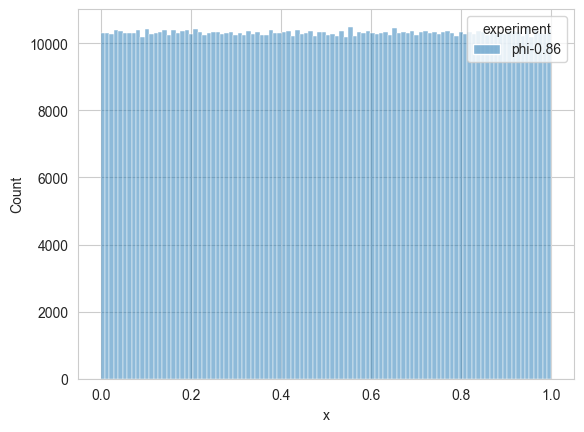

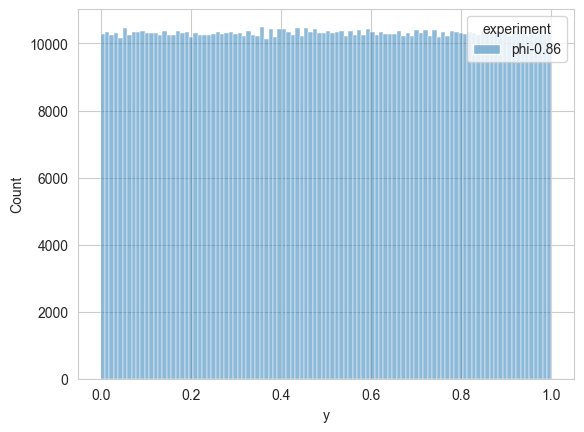

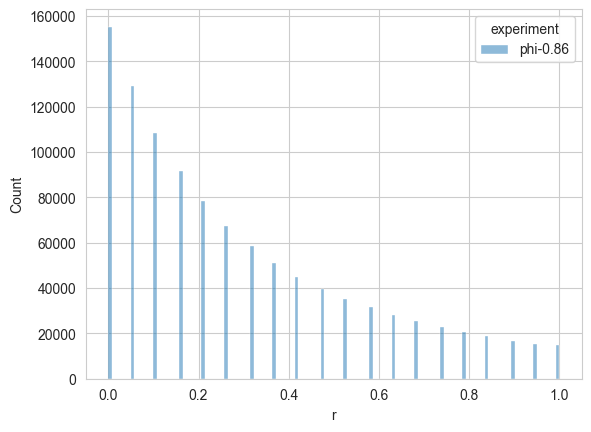

In [16]:
plt.figure()
sns.histplot(dataframe_scaled, x="x", hue="experiment", bins="auto")
plt.figure()
sns.histplot(dataframe_scaled, x="y", hue="experiment", bins="auto")
plt.figure()
sns.histplot(dataframe_scaled, x="r", hue="experiment", bins="auto")

x, y are uniform distributions

r seems to be an 1/x

# Create model

Create a GAN architecture, which creates point clouds $\hat{y}$ based on the descriptor(s) $\hat{X}$ and a random noise vector $\hat{z}$.

## Play around with models

In [17]:
sample_x = dataset[0:32][0].cpu()#.transpose(-1,-2)
sample_y = dataset[0:32][1].cpu()

print(sample_x.shape, sample_y.shape)

output_max_samples = 2000
in_dim = 1 # We have a single descriptor

kernel_y = 2000
kernel_x = 5

cnn_layers = 1
latent_max_samples = output_max_samples #+ cnn_layers*kernel_y # We will add some padding to the latent space

latent_dim = 3 # This you can change
batch_size = sample_x.shape[0]
cnn_channels = 1

# Takes in the input descriptors and returns the output point cloud

desc2latent = nn.Sequential(
            # Input to latent space
            nn.ConvTranspose1d(in_dim, latent_dim, kernel_size=latent_max_samples//2, stride=1, padding=0, bias=True),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(latent_dim, latent_dim, kernel_size=latent_max_samples//2-1, stride=1, padding=0, bias=True),
            nn.LeakyReLU(0.2),
        )

desc2latent_alt = nn.Sequential( # Do a version without the 1d transpose convolution
            nn.Linear(in_dim, latent_dim//4),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim//4, latent_dim),
            nn.LeakyReLU(0.2),
        )

# This is a good idea but difficult to implement with padding
zx = torch.rand(batch_size, latent_max_samples, 1) # X is uniform
zy = torch.rand(batch_size, latent_max_samples, 1) # Y is uniform
# R is inverse exponential
zr = torch.tensor(np.random.exponential(0.3, (batch_size, latent_max_samples, 1)), dtype=torch.float32)
z = torch.cat([zx, zy, zr], dim=-1)

# Simple way
# z = torch.rand(batch_size, latent_max_samples, latent_dim)

bias = False

activation = nn.LeakyReLU(0.2)
activation = nn.Sigmoid()

latent2pointcloud = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=(kernel_y+1, kernel_x), stride=1, padding="same", bias=True, padding_mode="zeros"),
            # activation,
            # nn.Conv2d(cnn_channels, cnn_channels, kernel_size=(kernel_y+1, kernel_x), stride=1, padding="same", bias=bias),
            # activation,
            # nn.Conv2d(cnn_channels, cnn_channels, kernel_size=(kernel_y+1, kernel_x), stride=1, padding="same", bias=bias),
            # activation,
            # nn.Conv2d(cnn_channels, cnn_channels, kernel_size=(kernel_y+1, kernel_x), stride=1, padding="same", bias=bias),
            # activation,
            # nn.Conv2d(cnn_channels, 1, kernel_size=(kernel_y+1, kernel_x), stride=1, padding="same", bias=bias, padding_mode="zeros"),
        )

for layer in latent2pointcloud:
    if hasattr(layer, "weight"):
        # nn.init.xavier_uniform_(layer.weight, gain=nn.init.calculate_gain('leaky_relu', 0.2))
        # nn.init.xavier_uniform_(layer.weight, gain=1)
        nn.init.uniform_(layer.weight, a=-0.1, b=0.1)

    # if bias:
    #     nn.init.uniform_(layer.bias, a=-0.01, b=0.01)

bn = nn.BatchNorm1d(3)



print("X:", sample_x.shape)
print("Z:", z.shape)

x = sample_x
x = desc2latent(x)
print("mean:", x.mean(), x.min(), x.max())
x = x.transpose(-1,-2)

print("Latent:", x.shape)
x = x + z
x = z
x = x.unsqueeze(1)

print("Latent random: ", x.shape)

x_latent = x

x = latent2pointcloud(x)

x = x.squeeze(1)

x = x.transpose(-1,-2)

x = bn(x).transpose(-1,-2)


print("Point cloud: ", x.shape)
# print("Latent reshaped:", desc2latent(sample_x_2d).reshape(batch_size, 1, -1, latent_dim).shape)
# print("Latent reshaped:", desc2latent(sample_x_2d).transpose(-1,-2).reshape(batch_size, 1, -1, latent_dim).shape)
# print("Output:", latent2pointcloud((desc2latent(sample_x_2d).reshape(batch_size, 1, -1, latent_dim))).shape)
# print(latent2pointcloud((desc2latent(sample_x_2d).transpose(-1,-2)*z)).shape)

# print(summary(latent2pointcloud,depth=1))
# print(summary(desc2latent, input_data=sample_x,depth=0))
print(summary(latent2pointcloud, input_data=x_latent, depth=1))
# latent2pointcloud(desc2latent(sample_x)*z).transpose(-1,-2).shape


torch.Size([32, 1, 3]) torch.Size([32, 2000, 3])
X: torch.Size([32, 1, 3])
Z: torch.Size([32, 2000, 3])
mean: tensor(0.0052, grad_fn=<MeanBackward0>) tensor(-0.0048, grad_fn=<MinBackward1>) tensor(0.0286, grad_fn=<MaxBackward1>)
Latent: torch.Size([32, 2000, 3])
Latent random:  torch.Size([32, 1, 2000, 3])


/Users/veikko/Documents/GitHub/hard-spheres/.venv/lib/python3.12/site-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Point cloud:  torch.Size([32, 2000, 3])
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 1, 2000, 3]          --
├─Conv2d: 1-1                            [32, 1, 2000, 3]          10,006
Total params: 10,006
Trainable params: 10,006
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.92
Input size (MB): 0.77
Forward/backward pass size (MB): 1.54
Params size (MB): 0.04
Estimated Total Size (MB): 2.34


Take a look at the "naive" latent space distribution and the one passed through the CNN to see that the CNN parameter distributions are correctly initialized 

<Axes: >

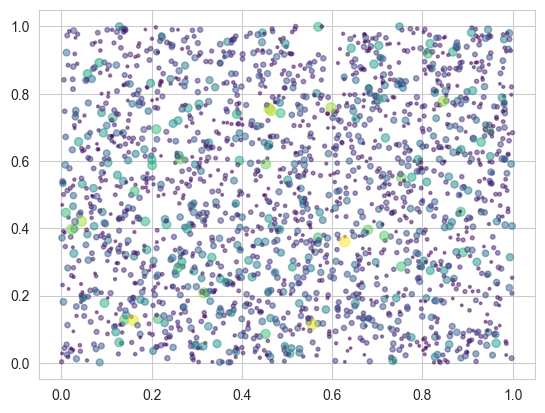

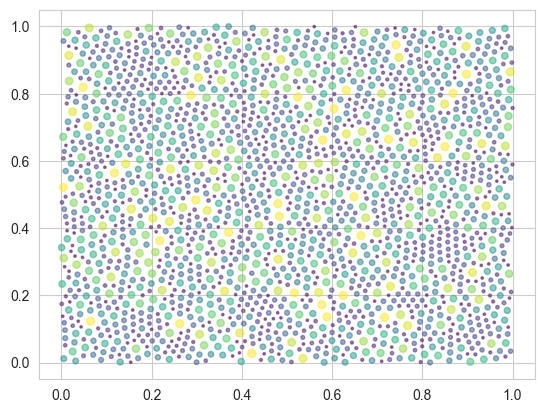

In [18]:
plot_pointcloud(z[0])
plot_pointcloud(dataset[2][1], plot_radius=True)


torch.Size([1, 3, 2000])


<Axes: >

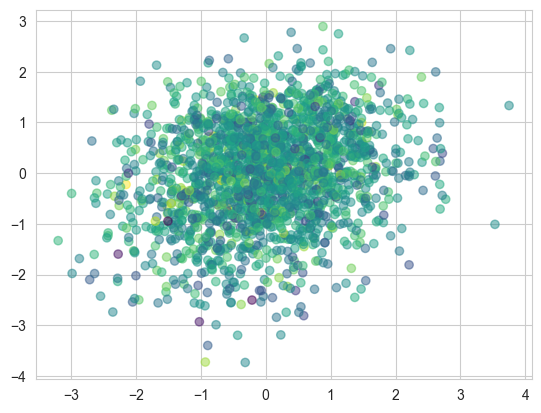

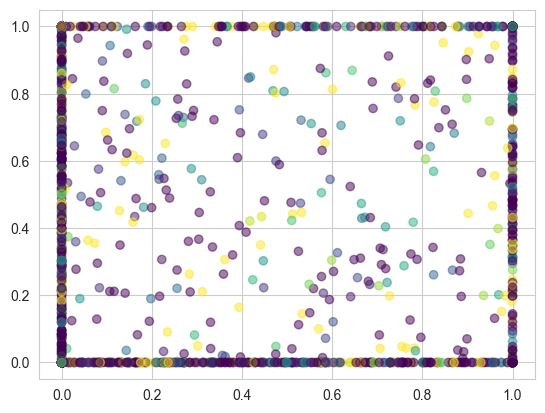

In [19]:
x = latent2pointcloud(z.unsqueeze(1)[0])
x = x.squeeze(1)

x = x.transpose(-1,-2)
print(x.shape)

x = bn(x).transpose(-1,-2)
x = x[0].detach()
# _out = _out.transpose(-1,-2)

# _out = bn(_out).transpose(-1,-2)

plot_pointcloud(x.numpy(), plot_radius=False)
x = torch.clip(x, 0, 1)
plot_pointcloud(x.numpy(), plot_radius=False)



In [20]:
# print(HSGenerator(output_max_samples=dataset.y.shape[1], latent_dim=27, in_dim=3)(sample_x).shape)

summary(
    HSGenerator(
        output_max_samples=dataset.y.shape[1],
        latent_dim=3,
        in_dim=3,
        cnn_channels=1,
        kernel_x=5, # Latent space is 3, so we need at least 3, but with 5 the kernel spans the entire latent space with padding
        kernel_y=4000, # This is the maximum number of samples we can have * 2
        latent2pointcloud_layers=2
        ), input_data=sample_x, depth=5
)


Layer (type:depth-idx)                   Output Shape              Param #
HSGenerator                              [32, 2000, 3]             4,007
├─Sequential: 1-1                        [32, 1, 2000, 3]          --
│    └─Conv2d: 2-1                       [32, 1, 2000, 3]          20,006
│    └─Sigmoid: 2-2                      [32, 1, 2000, 3]          --
│    └─Conv2d: 2-3                       [32, 1, 2000, 3]          20,005
│    └─Sigmoid: 2-4                      [32, 1, 2000, 3]          --
│    └─Conv2d: 2-5                       [32, 1, 2000, 3]          20,005
│    └─Conv2d: 2-6                       [32, 1, 2000, 3]          20,006
Total params: 84,029
Trainable params: 84,029
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 15.36
Input size (MB): 0.01
Forward/backward pass size (MB): 6.14
Params size (MB): 0.32
Estimated Total Size (MB): 6.47

In [20]:
print(sample_x.shape)
print(sample_y.shape)
HSDiscriminator(channels_img=1, features_d=4)(sample_y).shape

summary(HSDiscriminator(channels_img=1, features_d=32), input_data=sample_y, depth=2)

torch.Size([32, 1, 3])
torch.Size([32, 2000, 3])


Layer (type:depth-idx)                   Output Shape              Param #
HSDiscriminator                          [32, 1]                   --
├─Sequential: 1-1                        [32, 1]                   --
│    └─Conv2d: 2-1                       [32, 16, 969, 2]          2,064
│    └─LeakyReLU: 2-2                    [32, 16, 969, 2]          --
│    └─Sequential: 2-3                   [32, 32, 314, 3]          32,832
│    └─Sequential: 2-4                   [32, 32, 301, 4]          32,832
│    └─Conv2d: 2-5                       [32, 1, 298, 3]           257
│    └─LeakyReLU: 2-6                    [32, 1, 298, 3]           --
│    └─Flatten: 2-7                      [32, 894]                 --
│    └─MaxPool1d: 2-8                    [32, 178]                 --
│    └─Linear: 2-9                       [32, 32]                  5,728
│    └─LeakyReLU: 2-10                   [32, 32]                  --
│    └─Linear: 2-11                      [32, 1]                   33


## Another attempt

In [187]:
# Make a generator model as described in the paper
# paper: https://arxiv.org/pdf/2404.06734

in_features = 64
channels = [128, 256, 512, 256, 3]
kernel_size = (4,4)

generator_model_2 = nn.Sequential(
            nn.Flatten(1, -1),
            nn.Linear(3, in_features), # 33k
            nn.ReLU(True),
            # Fully connected layer
            # nn.Linear(in_features, 128 * 264), # 33k
            nn.Linear(in_features=in_features, out_features=1000*12), # 12k, half size
            nn.ReLU(True),
            
            # # Reshape to (128, 264, 1, 1)
            # nn.Unflatten(1, (128, 264, 1)),
            nn.Unflatten(1, (96, 125, 1)),
            
            # # Transposed Convolution 1
            nn.ConvTranspose2d(96, 256, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # # Transposed Convolution 2
            nn.ConvTranspose2d(256, 512, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            # # Transposed Convolution 3
            nn.ConvTranspose2d(512, 256, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # # Transposed Convolution 4
            nn.ConvTranspose2d(256, 3, kernel_size=kernel_size, stride=2, padding=1),
            
            # Flatten towards the resu shape
            # nn.Flatten(2,3),

            # Linear
            # nn.Linear(32000, 2000),
            nn.AvgPool2d(kernel_size=(1,16), stride=1, padding=0),
            nn.Flatten(1, -1),
            nn.Unflatten(1, (2000, 3)),
            nn.Sigmoid(),
        ).to("mps")

__sample_x = torch.rand(batch_size, 64, device="mps")
sample_x
print(sample_x.shape)
print(generator_model_2(sample_x).shape)

summary(generator_model_2, input_data=sample_x, depth=2)

torch.Size([32, 1, 3])
torch.Size([32, 2000, 3])


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 2000, 3]             --
├─Flatten: 1-1                           [32, 3]                   --
├─Linear: 1-2                            [32, 64]                  256
├─ReLU: 1-3                              [32, 64]                  --
├─Linear: 1-4                            [32, 12000]               780,000
├─ReLU: 1-5                              [32, 12000]               --
├─Unflatten: 1-6                         [32, 96, 125, 1]          --
├─ConvTranspose2d: 1-7                   [32, 256, 250, 2]         393,472
├─BatchNorm2d: 1-8                       [32, 256, 250, 2]         512
├─ReLU: 1-9                              [32, 256, 250, 2]         --
├─ConvTranspose2d: 1-10                  [32, 512, 500, 4]         2,097,664
├─BatchNorm2d: 1-11                      [32, 512, 500, 4]         1,024
├─ReLU: 1-12                             [32, 512, 500, 4]     

In [199]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Flatten(1, -1),
            nn.Unflatten(1, (3, 2000)),

            # Unflatten from 3x2000 to 3x125x16
            nn.Unflatten(2, (125, 16)),

            # Convolutional layer 1
            nn.Conv2d(input_channels, 128, kernel_size=(4, 4), stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # # Convolutional layer 2
            nn.Conv2d(128, 128, kernel_size=(4, 4), stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # # Convolutional layer 3
            nn.Conv2d(128, 64, kernel_size=(4, 4), stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # # Average Pooling
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        
        self.fc_layers = nn.Sequential(
            # Fully connected layers
            nn.Linear(64, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 10),
            nn.AdaptiveAvgPool1d(1),

        )

    def forward(self, input):
        conv_output = self.main(input)
        conv_output_flat = conv_output.view(conv_output.size(0), -1)  # Flatten
        output = self.fc_layers(conv_output_flat)
        return output

# Initialize the discriminator
input_channels = 3  # Change to 6 for bond distances
discriminator_model_2 = Discriminator(input_channels).to("mps")

# Print the discriminator architecture

# Example input with batch size of 16 and 3 input channels (for fractional coordinates)
batch_size = batch_size
input_data = torch.randn(batch_size, 3, 264, 264)  # Change to (batch_size, 6, 264, 264) for bond distances

# Generate output

print(sample_y.shape)
output = discriminator_model_2(sample_y)
print(output.shape)

summary(discriminator_model_2, input_data=sample_y, depth=2)


torch.Size([32, 2000, 3])
torch.Size([32, 1])


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [32, 1]                   --
├─Sequential: 1-1                        [32, 64, 1, 1]            --
│    └─Flatten: 2-1                      [32, 6000]                --
│    └─Unflatten: 2-2                    [32, 3, 2000]             --
│    └─Unflatten: 2-3                    [32, 3, 125, 16]          --
│    └─Conv2d: 2-4                       [32, 128, 62, 8]          6,272
│    └─LeakyReLU: 2-5                    [32, 128, 62, 8]          --
│    └─Conv2d: 2-6                       [32, 128, 31, 4]          262,272
│    └─LeakyReLU: 2-7                    [32, 128, 31, 4]          --
│    └─Conv2d: 2-8                       [32, 64, 15, 2]           131,136
│    └─LeakyReLU: 2-9                    [32, 64, 15, 2]           --
│    └─AdaptiveAvgPool2d: 2-10           [32, 64, 1, 1]            --
├─Sequential: 1-2                        [32, 1]                   --
│ 

## Train the model

In [189]:
run_params = {
    "training":{
        "device": "mps" if torch.backends.mps.is_available() else "cpu", # MPS is not supported by PyTorch 2D TransposeConv
        "batch_size": 32,
        "epochs": 300,
        "early_stopping_patience": -1, # Disabled
        "early_stopping_headstart": 20,
        "log_image_frequency": 1,
        "generator_headstart": 0,
        "training_ratio_dg": 5,
        "optimizer_g": {
            "name": "Adam",
            "lr": 0.0002,
            "weight_decay": 0,
            "betas": (0.5, 0.999)
        },
        "optimizer_d": {
            "name": "Adam",
            "lr": 0.0002,
            "weight_decay": 0,
            "betas": (0.5, 0.999)
        },
        "d_loss":{
            "name": "BCELoss",
        },
        "g_loss":{
            "name": "HSGeneratorLoss",
            "radius_loss": 0,
            "grid_density_loss": 0,
            "gan_loss": 1
        }
    },
    # "generator": {
    #     "output_max_samples": dataset.y.shape[1],
    #     "in_dim": 3,
    #     "latent_dim": 3,
    #     "cnn_channels": 8,
    #     "output_max_samples": 2000,
    #     "kernel_y":4000,
    #     "kernel_x":5,
    #     "latent2pointcloud_layers":0, # input and output are excluded so n + 2
    # },
    # "discriminator": {
    #     "channels_img":1,
    #     "features_d": 32
    # }
}
run_params

{'training': {'device': 'mps',
  'batch_size': 32,
  'epochs': 300,
  'early_stopping_patience': -1,
  'early_stopping_headstart': 20,
  'log_image_frequency': 1,
  'generator_headstart': 0,
  'training_ratio_dg': 5,
  'optimizer_g': {'name': 'Adam',
   'lr': 0.0002,
   'weight_decay': 0,
   'betas': (0.5, 0.999)},
  'optimizer_d': {'name': 'Adam',
   'lr': 0.0002,
   'weight_decay': 0,
   'betas': (0.5, 0.999)},
  'd_loss': {'name': 'BCELoss'},
  'g_loss': {'name': 'HSGeneratorLoss',
   'radius_loss': 0,
   'grid_density_loss': 0,
   'gan_loss': 1}}}

In [190]:
test_frac = 0.2

dataset = dataset.to(run_params["training"]["device"])

trainset, testset = torch.utils.data.random_split(dataset, [1-test_frac, test_frac])

sample_x = dataset[0:32][0]#.transpose(-1,-2)
sample_y = dataset[0:32][1]

len(trainset), len(testset)

(421, 105)

In [191]:
gan = GAN(
    trainset,
    testset,
    generator_model=generator_model_2,
    discriminator_model=discriminator_model_2,
    **run_params
    )


print(summary(gan.generator, input_data=sample_x, depth=2))
print(summary(gan.discriminator, input_data=sample_y, depth=2))


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 2000, 3]             --
├─Flatten: 1-1                           [32, 3]                   --
├─Linear: 1-2                            [32, 64]                  256
├─ReLU: 1-3                              [32, 64]                  --
├─Linear: 1-4                            [32, 12000]               780,000
├─ReLU: 1-5                              [32, 12000]               --
├─Unflatten: 1-6                         [32, 96, 125, 1]          --
├─ConvTranspose2d: 1-7                   [32, 256, 250, 2]         393,472
├─BatchNorm2d: 1-8                       [32, 256, 250, 2]         512
├─ReLU: 1-9                              [32, 256, 250, 2]         --
├─ConvTranspose2d: 1-10                  [32, 512, 500, 4]         2,097,664
├─BatchNorm2d: 1-11                      [32, 512, 500, 4]         1,024
├─ReLU: 1-12                             [32, 512, 500, 4]     

<Axes: >

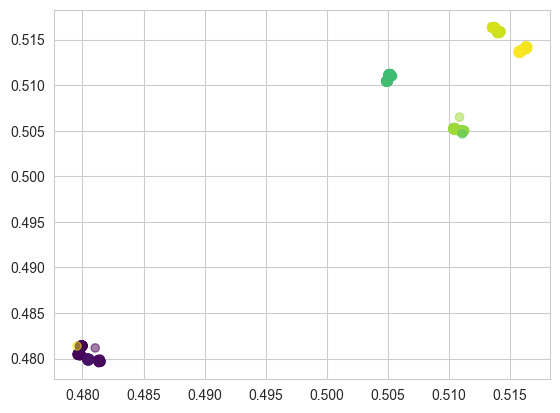

In [192]:
_out = gan.generate(sample_x)[0]
_out = _out.numpy()

plot_pointcloud(_out, plot_radius=False)


2024/07/04 20:34:33 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/07/04 20:34:33 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run tree-tree-74eee5bd-9623-41a8-971a-743da20fd6bf...
Time: 2024-07-04 20:34:33


  0%|          | 0/300 [00:00<?, ?it/s]
2024/07/04 20:34:34 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/04 20:34:34 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


RuntimeError: a Tensor with 64 elements cannot be converted to Scalar

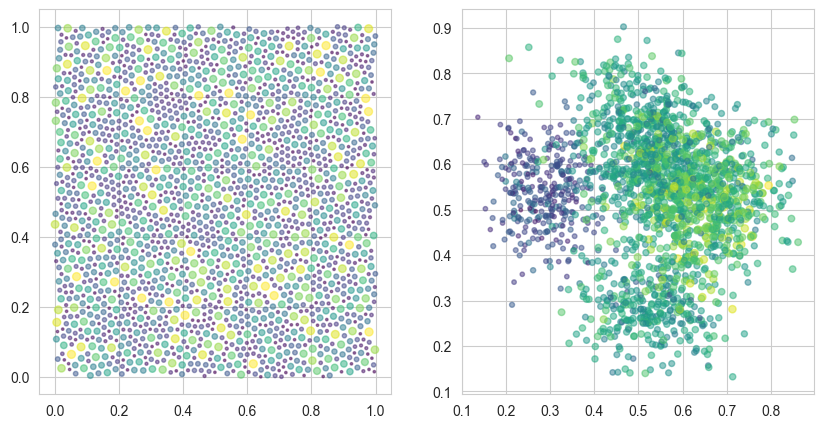

In [193]:
gan.train_n_epochs(
    epochs=run_params["training"]["epochs"],
    batch_size=run_params["training"]["batch_size"],
    experiment_name="MLFlow test 3",
    comment="",
)

In [41]:
# Run hyper parameter optimization
 
# Define the hyperparameter search space

batch_sizes = [32, 64, 128]
lrs_d = [0.001, 0.0001, 0.00001]
lrs_g = [0.001, 0.0001, 0.00001]

# Run experiments

this_run_params = deepcopy(run_params)

try:
    for batch_size in batch_sizes:
        for lr_d in lrs_d:
            for lr_g in lrs_g:
                this_run_params["training"]["batch_size"] = batch_size
                this_run_params["training"]["optimizer_g"]["lr"] = lr_g
                this_run_params["training"]["optimizer_d"]["lr"] = lr_d
                gan = GAN(trainset, testset, **this_run_params)
                gan.train_n_epochs(
                    epochs=this_run_params["training"]["epochs"],
                    batch_size=this_run_params["training"]["batch_size"],
                    experiment_name="Hparam search 5",
                    comment="",
                )
except KeyboardInterrupt:
    print("Interrupted")

Starting run cloud-star-e92782ff-7969-4bba-aa1b-93a6b501bf40...
Time: 2024-06-24 00:52:02


  0%|          | 0/300 [00:00<?, ?it/s]/Users/veikko/Documents/GitHub/hard-spheres/.venv/lib/python3.12/site-packages/hypergrad/adam_hd.py:71: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha = 1) (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:1581.)
  grad = grad.add(group['weight_decay'], p.data)
  1%|          | 2/300 [00:41<1:43:24, 20.82s/it]


Interrupted
Starting run tree-tree-532c8b5b-058a-4386-80a9-b55e7e6ffd9b...
Time: 2024-06-24 00:52:44


  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
latent_max_samples = 2000

zx = torch.rand(batch_size, latent_max_samples, 1) # X is uniform
zy = torch.rand(batch_size, latent_max_samples, 1) # Y is uniform
# R is inverse exponential
zr = torch.tensor(np.random.exponential(0.3, (batch_size, latent_max_samples, 1)), dtype=torch.float32)
z = torch.cat([zx, zy, zr], dim=-1)
plt.set_cmap("viridis")
plot_pointcloud(z[0], plot_radius=False)


In [ ]:
# Set torch random seed for reproducibility
torch.manual_seed(0)

mock_data = torch.rand([50, 3])
mock_data[:,2] *= 1

plot_pointcloud(mock_data)

def make_subgrid_mask_1d(lims, n):
    lo, hi = lims
    step = (hi - lo) / n
    grid = torch.linspace(lo+step, hi-step, steps=n-1)
    return grid

def make_subgrid_mask2d(lims_x, lims_y, n_x, n_y):
    # Break x-y in evenly distributed grid squares
    
    grid_x = make_subgrid_mask_1d(lims_x, n_x)
    grid_y = make_subgrid_mask_1d(lims_y, n_y)

    return grid_x, grid_y

def count_subgrid_density(pointcloud):
    # Expecting a pointcloud of format x,y,r

    grid_steps = 4
    lims = [0,1]

    grid_x, grid_y = make_subgrid_mask2d(lims, lims, grid_steps, grid_steps)

    # Mask the pointcloud for each step, returning a (samples, steps) matrix

    xcoords = pointcloud[:,0].unsqueeze(0)
    mask_x = (grid_x > xcoords.T).int()

    ycoords = pointcloud[:,1].unsqueeze(0)
    mask_y = (grid_y > ycoords.T).int() 

    mask_x = mask_x.sum(axis=1).unsqueeze(1)
    mask_y = mask_y.sum(axis=1).unsqueeze(1)
    grid_coordinates = torch.concat([mask_x, mask_y], dim=1)

    # count_per_grid = # TODO: Implement

    return grid_coordinates


count_subgrid_density(mock_data)


In [33]:
dataset[0:3][1].shape

torch.Size([3, 2000, 3])

In [32]:
n = 5

gan.generator(dataset[n][0]).detach().shape

NameError: name 'gan' is not defined

In [1]:
# Check on the created figures

plot_sample_figures(gan.generator, gan.discriminator, dataset, n=2, plot_radius=True)

NameError: name 'plot_sample_figures' is not defined

In [ ]:
"experiment_name==prwt-model-training-pipeline-60min"

## Ideas
- Divide the box into N (16) sub-boxes (not too small)
- (Subbox) density in the loss function
- Add Overlap loss

In [299]:
__y = sample_y[0].cpu()

print(__y.shape)

distances = torch.cdist(__y[:, :2], __y[:, :2])

# If distances < radius then we have a collision
radius_combinations = __y[:,2].unsqueeze(0) + __y[:,2].unsqueeze(1)

collisions = distances < radius_combinations

# Only consider the upper triangle
collisions = torch.triu(collisions, diagonal=1)

# Get the colliding point
collisions = torch.where(collisions)

# Get the colliding points
colliding_points = torch.unique(collisions[0])

colliding_points.shape


# plot_pointcloud(__y[indices,:], plot_radius=True)

torch.Size([2000, 3])


torch.Size([1998])

In [311]:
r = 1.

vec = torch.tensor([[0., 0., r], [1.,1., r], [2.,2., r*3]])

distances = torch.cdist(vec, vec)
print(distances)
# If distances < radius then we have a collision
radius_combinations = vec[:,2].unsqueeze(0) + vec[:,2].unsqueeze(1)

collisions = distances < radius_combinations

# Only consider the upper triangle
collisions = torch.triu(collisions, diagonal=1)

# Get the colliding points
collisions = torch.where(collisions)

# Get the colliding points
colliding_points = torch.unique(collisions[0])

colliding_points


tensor([[0.0000, 1.4142, 3.4641],
        [1.4142, 0.0000, 2.4495],
        [3.4641, 2.4495, 0.0000]])


tensor([0, 1])

In [ ]:
# Check physical feasibility of the generated point clouds

# Start with summing overlapping areas

def count_overlaps(xs, ys, rs):
    # Count the number of overlaps in the pointcloud
    # Overlapping areas are areas where the radius of a point is larger than the distance to the nearest point minus the radius of the nearest point

    # n_points = pointclouds.shape[0]
    # overlaps = 0

    # distances = torch.cdist(pointclouds, pointclouds)
    pass
    

   


# Check if the sum of overlapping areas is correct
# pointclouds = dataset[:][1]
# count_overlaps(pointclouds)


# Profile model performance for computational bottlenecks

In [152]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        gan.generator(sample_x)

    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


In [151]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 model_inference         0.64%       2.129ms       100.00%     332.285ms     332.285ms             1  
                aten::batch_norm         0.00%       6.208us        98.77%     328.188ms     164.094ms             2  
    aten::_batch_norm_impl_index         0.00%      16.417us        98.77%     328.181ms     164.091ms             2  
         aten::native_batch_norm        98.75%     328.147ms        98.76%     328.164ms     164.082ms             2  
                    aten::conv2d         0.00%       8.125us         0.18%     611.590us     203.863us             3  
               aten::convolution         0.01%  

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        gan.discriminator(sample_y)

    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


: 

In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        26.75%       4.685ms       100.00%      17.513ms      17.513ms             1  
                     aten::conv2d         0.22%      39.000us        58.93%      10.321ms       2.064ms             5  
                aten::convolution         0.50%      88.000us        58.71%      10.282ms       2.056ms             5  
               aten::_convolution         0.36%      63.000us        58.21%      10.194ms       2.039ms             5  
         aten::mkldnn_convolution        57.36%      10.045ms        57.85%      10.131ms       2.026ms             5  
                 aten::leaky_relu       

### OPEN QUESTIONS

- What to do with the metadata?
- Class and radius are redundant. Is the real physical measure numerical or categorical / quantified? 

In [ ]:
metadata.round(5).drop_duplicates()

,,N,L,A
experiment,sample,,,
phi-0.74,sample-245,2000,46.88709,1626.81571
phi-0.72,sample-245,2000,47.53384,1626.81571
phi-0.70,sample-245,2000,48.20812,1626.81571
